# Forest Cover Classification Project

This project uses deep learning to predict forest cover type (the most common kind of tree cover) based only on cartographic variables.

The actual forest cover type for a given 30 x 30 meter cell was determined from US Forest Service (USFS) Region 2 Resource Information System data. The covertypes are the following:

Spruce/Fir
Lodgepole Pine
Ponderosa Pine
Cottonwood/Willow
Aspen
Douglas-fir
Krummholz

Independent variables were then derived from data obtained from the US Geological Survey and USFS. This study area includes four wilderness areas located in the Roosevelt National Forest of northern Colorado. These areas represent forests with minimal human-caused disturbances, so existing forest cover types are mainly a result of ecological processes rather than forest management practices.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow	import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

### Load Data
Investigate data to gain familarity.

In [2]:
df = pd.read_csv(r'C:\Users\DaReaders\Downloads\dlsp-portfolio-solution-code\dlsp-portfolio-solution-code\cover_data.csv')
df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,class
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [3]:
df.shape

(581012, 55)

The data contains 581012 observations. Each observation have 55 columns; 54 features, the last column is the class.

In [4]:
#Check for missing data
print(df.isnull().sum())

Elevation                             0
Aspect                                0
Slope                                 0
Horizontal_Distance_To_Hydrology      0
Vertical_Distance_To_Hydrology        0
Horizontal_Distance_To_Roadways       0
Hillshade_9am                         0
Hillshade_Noon                        0
Hillshade_3pm                         0
Horizontal_Distance_To_Fire_Points    0
Wilderness_Area1                      0
Wilderness_Area2                      0
Wilderness_Area3                      0
Wilderness_Area4                      0
Soil_Type1                            0
Soil_Type2                            0
Soil_Type3                            0
Soil_Type4                            0
Soil_Type5                            0
Soil_Type6                            0
Soil_Type7                            0
Soil_Type8                            0
Soil_Type9                            0
Soil_Type10                           0
Soil_Type11                           0


Great we have no missing data. Obtain a summary statistics on the data

In [5]:
df.describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,class
count,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,...,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000
mean,2959.365301,155.656807,14.103704,269.428217,46.418855,2350.146611,212.146049,223.318716,142.528263,1980.291226,...,0.090392,0.077716,0.002773,0.003255,0.000205,0.000513,0.026803,0.023762,0.015060,2.051471
std,279.984734,111.913721,7.488242,212.549356,58.295232,1559.254870,26.769889,19.768697,38.274529,1324.195210,...,0.286743,0.267725,0.052584,0.056957,0.014310,0.022641,0.161508,0.152307,0.121791,1.396504
min,1859.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2809.000000,58.000000,9.000000,108.000000,7.000000,1106.000000,198.000000,213.000000,119.000000,1024.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,2996.000000,127.000000,13.000000,218.000000,30.000000,1997.000000,218.000000,226.000000,143.000000,1710.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,3163.000000,260.000000,18.000000,384.000000,69.000000,3328.000000,231.000000,237.000000,168.000000,2550.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
max,3858.000000,360.000000,66.000000,1397.000000,601.000000,7117.000000,254.000000,254.000000,254.000000,7173.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000


### Split data into labels and features

In [6]:
labels = df.iloc[:, -1] 
features = df.iloc[:, 0:-1]

### Split data into training set and test sets

In [7]:
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = 0.20, 
                                                                            random_state=42)

### Normalize the data

In [8]:
scaler = StandardScaler()
features_train_scaled = scaler.fit_transform(features_train)
features_test_scaled = scaler.transform(features_test)

## Create a neural network model

In [9]:
def design_model(X):
    model = Sequential()
    input = tf.keras.Input(shape=(X.shape[1],))
    model.add(Dense(64, activation='relu'))
    #model.add(Dropout(0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(8, activation='softmax'))
    #Initalize the optimizer and compile the model
    #Create an instance of Adam optimizer
    opt = Adam(learning_rate = 0.001)
    model.compile(loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'], optimizer = opt)
    return model

In [10]:
# Apply the model to the scaled training data
model = design_model(features_train_scaled)


### Fit the model

In [11]:
# Apply early stopping for efficiency
es = EarlyStopping(monitor='val_accuracy', mode='min', verbose=1, patience=20)

In [12]:
history = model.fit(features_train_scaled, labels_train, epochs = 500, batch_size = 1000, verbose = 1, 
                    validation_split = 0.2, callbacks = [es])

Epoch 1/500
372/372 [==============================] - 1s 4ms/step - loss: 0.7727 - accuracy: 0.6943 - val_loss: 0.6103 - val_accuracy: 0.7421
Epoch 2/500
372/372 [==============================] - 1s 3ms/step - loss: 0.5843 - accuracy: 0.7527 - val_loss: 0.5634 - val_accuracy: 0.7598
Epoch 3/500
372/372 [==============================] - 1s 3ms/step - loss: 0.5488 - accuracy: 0.7675 - val_loss: 0.5362 - val_accuracy: 0.7720
Epoch 4/500
372/372 [==============================] - 1s 3ms/step - loss: 0.5254 - accuracy: 0.7775 - val_loss: 0.5143 - val_accuracy: 0.7814
Epoch 5/500
372/372 [==============================] - 1s 3ms/step - loss: 0.5083 - accuracy: 0.7837 - val_loss: 0.4975 - val_accuracy: 0.7877
Epoch 6/500
372/372 [==============================] - 1s 3ms/step - loss: 0.4943 - accuracy: 0.7890 - val_loss: 0.4880 - val_accuracy: 0.7901
Epoch 7/500
372/372 [==============================] - 1s 3ms/step - loss: 0.4815 - accuracy: 0.7949 - val_loss: 0.4732 - val_accuracy: 0.7971

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                3520      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 264       
Total params: 5,864
Trainable params: 5,864
Non-trainable params: 0
_________________________________________________________________


### Evaluate the model

In [14]:
score = model.evaluate(features_test_scaled, labels_test, verbose=0)
print(f'Test loss: {score[0]}')
print(f'Test accuracy: {score[1]}')

Test loss: 0.4034586250782013
Test accuracy: 0.8324655890464783


## Plot some performance metrics

### Classification Report

In [15]:
y_pred = model.predict(features_test_scaled)

# Convert the pred to discrete values
y_pred = np.argmax(y_pred, axis=1)
class_names = ['Spruce/Fir', 'Lodgepole Pine',
               'Ponderosa Pine', 'Cottonwood/Willow',
               'Aspen', 'Douglas-fir', 'Krummholz']
print(classification_report(labels_test, y_pred, target_names=class_names))

                   precision    recall  f1-score   support

       Spruce/Fir       0.86      0.80      0.83     42557
   Lodgepole Pine       0.83      0.90      0.86     56500
   Ponderosa Pine       0.79      0.84      0.81      7121
Cottonwood/Willow       0.74      0.65      0.69       526
            Aspen       0.73      0.33      0.46      1995
      Douglas-fir       0.66      0.54      0.59      3489
        Krummholz       0.84      0.84      0.84      4015

         accuracy                           0.83    116203
        macro avg       0.78      0.70      0.73    116203
     weighted avg       0.83      0.83      0.83    116203



### Plot the accuracy and loss for both the train and validation data over each epoch

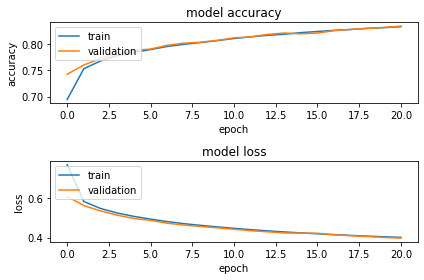

In [16]:
fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('model accuracy')
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.legend(['train', 'validation'], loc='upper left')

ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('model loss')
ax2.set_xlabel('epoch')
ax2.set_ylabel('loss')
ax2.legend(['train', 'validation'], loc='upper left')
 
# used to keep plots from overlapping
fig.tight_layout()

plt.show()

### Heatmap

[Text(0, 0.5, 'Spruce/Fir'),
 Text(0, 1.5, 'Lodgepole Pine'),
 Text(0, 2.5, 'Ponderosa Pine'),
 Text(0, 3.5, 'Cottonwood/Willow'),
 Text(0, 4.5, 'Aspen'),
 Text(0, 5.5, 'Douglas-fir'),
 Text(0, 6.5, 'Krummholz')]

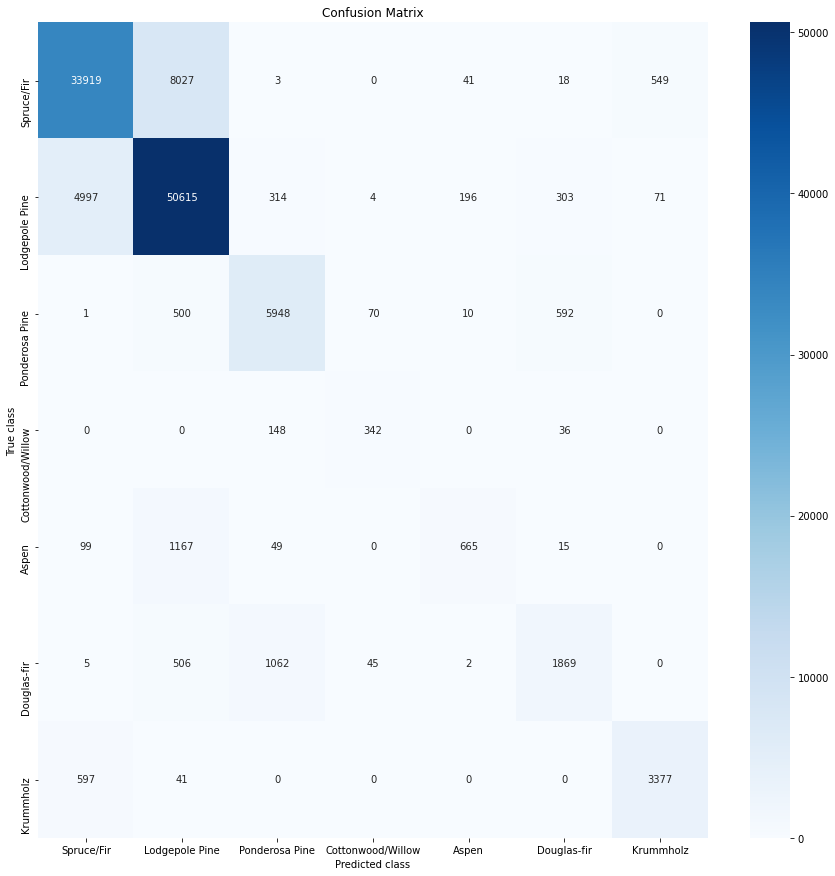

In [17]:
cm = confusion_matrix(labels_test, y_pred)
fig, ax = plt.subplots(figsize=(15, 15))
heatmap = sns.heatmap(cm, fmt='g', cmap='Blues', annot=True, ax=ax)
ax.set_xlabel('Predicted class')
ax.set_ylabel('True class')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)


## Conculsions

This project provided opporturnity to practice adjusting hyperparameters, early stopping was added to prevent overfitting. Various hyperparameters were adjusted to improve the model's performance. Accuracy of 0.83 was achieved by adding an activation function to the last layer. 

Based on the metrics; classification report and confusion matrix, the model provided a good classification of most of the forest cover. However, Cottonwood Willow, Aspen and Douglas-Fir had low F1-scores and high percentage of mis-classifications.


